In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 4  # Normal + 2 types of keratitis + Other class

In [ ]:
def load_image_data(image_dir, labels):
    images = []
    image_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            if not os.path.isfile(img_path):  # Skip directories
                continue
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                image_labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    images = np.array(images) / 255.0  # Normalize
    return images, image_labels


In [ ]:
image_dir = "C:\\Users\\prart\\Downloads\\FINAL DATASET\\FINAL DATASET"
labels = ["Fusarium Keratitis Mild", "Fusarium Keratitis Severe", "No Keratitis"]
images, image_labels = load_image_data(image_dir, labels)

print("Unique labels in dataset:", set(image_labels))

Unique labels in dataset: {'Fusarium Keratitis Mild', 'No Keratitis', 'Fusarium Keratitis Severe'}


In [ ]:
(x_train_cifar, y_train_cifar), (_, _) = tf.keras.datasets.cifar10.load_data()
cifar_images = []

for i in range(2000):  # Using only 2000 random images to balance dataset
    img = tf.image.resize(x_train_cifar[i], IMAGE_SIZE).numpy() / 255.0
    cifar_images.append(img)

cifar_images = np.array(cifar_images)
cifar_labels = ["Other"] * len(cifar_images)


In [ ]:
all_images = np.concatenate((images, cifar_images), axis=0)
all_labels = image_labels + cifar_labels

In [ ]:
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    return encoded_labels, label_encoder

encoded_labels, label_encoder = encode_labels(all_labels)
print(label_encoder.classes_)  # Check class labels

['Fusarium Keratitis Mild' 'Fusarium Keratitis Severe' 'No Keratitis'
 'Other']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    all_images, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)


In [ ]:
def build_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
model = build_cnn_model(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)




Epoch 1/20


167/167 [==============================] - 201s 995ms/step - loss: 1.3724 - accuracy: 0.6194 - val_loss: 4.7933 - val_accuracy: 0.3261
Epoch 2/20
167/167 [==============================] - 106s 636ms/step - loss: 0.7415 - accuracy: 0.6783 - val_loss: 8.3018 - val_accuracy: 0.4711
Epoch 3/20
167/167 [==============================] - 113s 679ms/step - loss: 0.6706 - accuracy: 0.7123 - val_loss: 0.7048 - val_accuracy: 0.6754
Epoch 4/20
167/167 [==============================] - 110s 660ms/step - loss: 0.5742 - accuracy: 0.7485 - val_loss: 0.6877 - val_accuracy: 0.7025
Epoch 5/20
167/167 [==============================] - 112s 673ms/step - loss: 0.4910 - accuracy: 0.7918 - val_loss: 0.6906 - val_accuracy: 0.6777
Epoch 6/20
167/167 [==============================] - 108s 649ms/step - loss: 0.4170 - accuracy: 0.8226 - val_loss: 3.7701 - val_accuracy: 0.6649
Epoch 7/20
167/167 [==============================] - 108s 649ms/step - loss: 0.3372 - accuracy: 0.8630 - val_loss: 0.63

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

42/42 [==============================] - 7s 166ms/step - loss: 1.0943 - accuracy: 0.7761
Test Accuracy: 77.61%
167/167 [==============================] - 27s 154ms/step - loss: 0.0241 - accuracy: 0.9921
Train Accuracy: 99.21%


42/42 [==============================] - 10s 165ms/step
                           precision    recall  f1-score   support

  Fusarium Keratitis Mild       0.81      0.74      0.78       385
Fusarium Keratitis Severe       0.58      0.49      0.53       267
             No Keratitis       0.62      0.77      0.69       279
                    Other       1.00      1.00      1.00       400

                 accuracy                           0.78      1331
                macro avg       0.75      0.75      0.75      1331
             weighted avg       0.78      0.78      0.77      1331



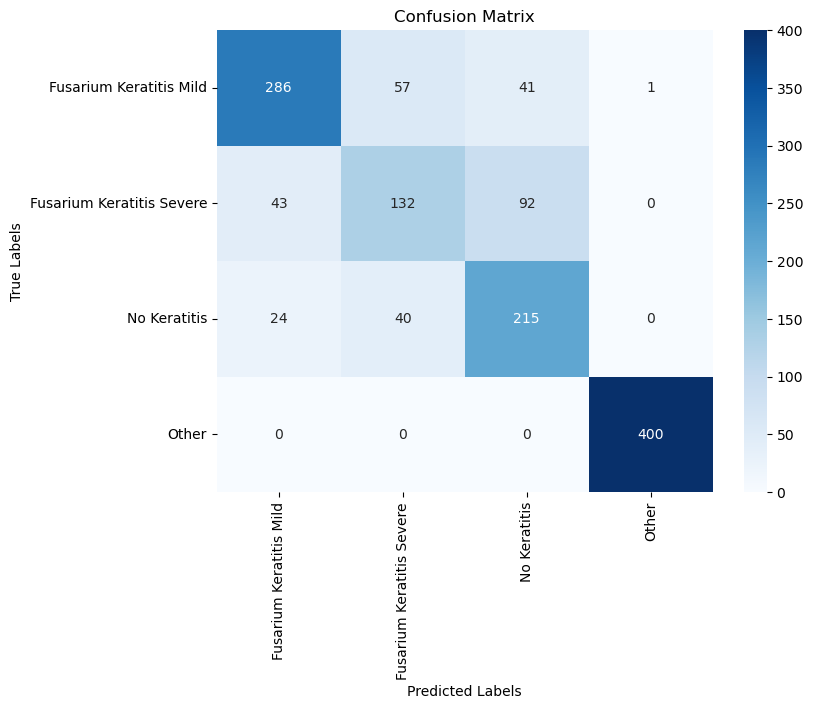

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


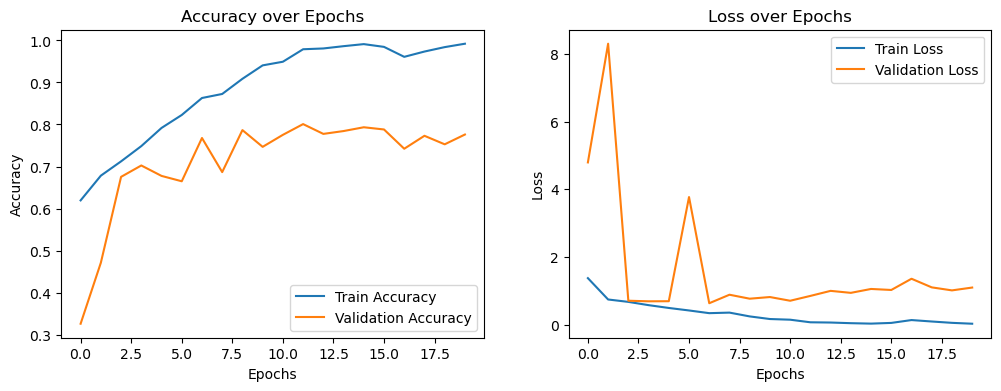

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


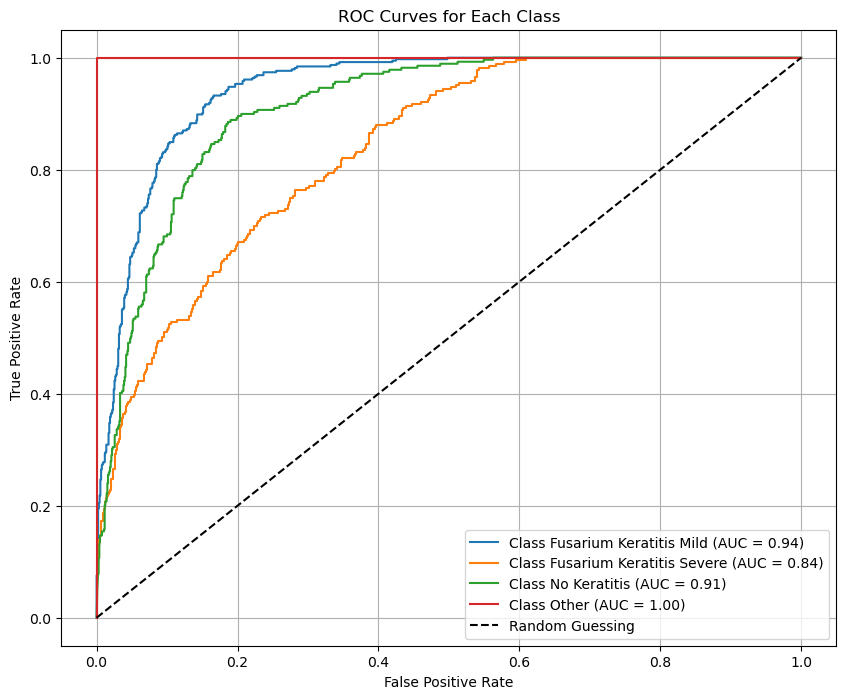

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, label=f"Class {label_encoder.classes_[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.title("ROC Curves for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


1/1 [==============================] - 0s 110ms/step


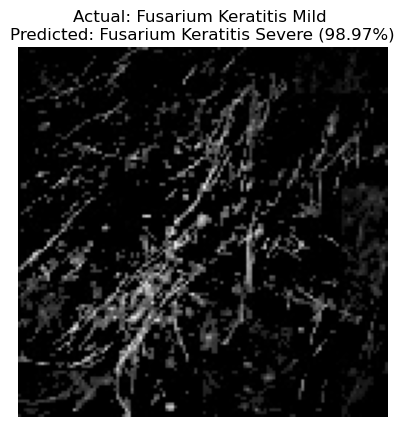

In [ ]:
example_index = 0
example_image = np.expand_dims(X_test[example_index], axis=0)
example_prediction = model.predict(example_image)
predicted_class = np.argmax(example_prediction, axis=1)[0]
predicted_label = label_encoder.inverse_transform([predicted_class])[0]

plt.imshow(X_test[example_index])
plt.axis("off")

actual_class = np.argmax(y_test[example_index])
actual_label = label_encoder.inverse_transform([actual_class])[0]

plt.title(f"Actual: {actual_label} \nPredicted: {predicted_label} ({np.max(example_prediction) * 100:.2f}%)")
plt.show()


In [ ]:
def predict_image(image_path, model, label_encoder):
    # Load image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for model input

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    # Display Image & Prediction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label} ({np.max(prediction) * 100:.2f}%)")
    plt.show()


1/1 [==============================] - 0s 46ms/step


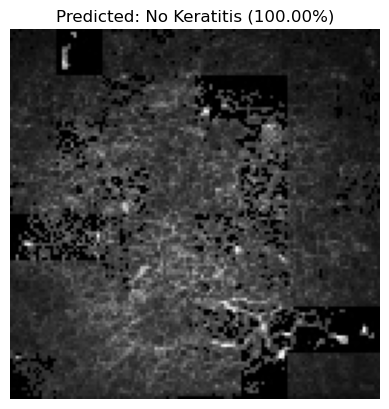

In [ ]:
image_path = "C:\\Users\\prart\\Downloads\\FINAL DATASET\\FINAL DATASET\\No Keratitis\\Mucor_mild_Y_201507302OS_9.jpg"  # Replace with your image path
predict_image(image_path, model, label_encoder)


1/1 [==============================] - 0s 52ms/step


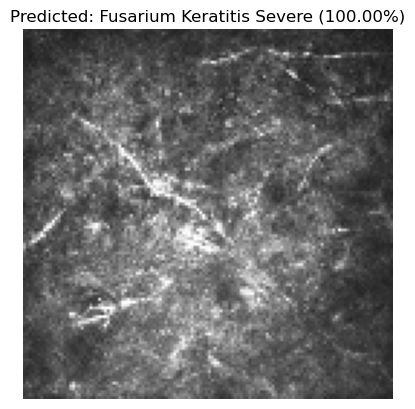

In [ ]:
image_path = "C:\\Users\\prart\\Downloads\\FINAL DATASET\\FINAL DATASET\\Fusarium Keratitis Severe\\Fusarium_severe_X_2018.04.27-OD_19.jpg"  # Replace with your image path
predict_image(image_path, model, label_encoder)


1/1 [==============================] - 0s 60ms/step


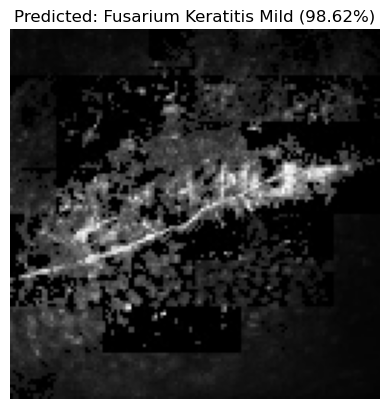

In [ ]:
image_path = "C:\\Users\\prart\\Downloads\\FINAL DATASET\\FINAL DATASET\\Fusarium Keratitis Mild\\Fusarium_mild_V_OD20170406_402.jpg"  # Replace with your image path
predict_image(image_path, model, label_encoder)


#Saved Model

In [ ]:
# Save model and label encoder
model.save("keratitis_classifier.h5")  # Save model in HDF5 format
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)  # Save label encoder
print("Model and label encoder saved successfully!")


C:\Users\prart\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model and label encoder saved successfully!


In [ ]:
import shutil

# Save model and label encoder
model.save("keratitis_classifier.h5")
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Zip the files for downloading
shutil.make_archive("keratitis_model", 'zip', ".", "keratitis_classifier.h5")
shutil.make_archive("label_encoder", 'zip', ".", "label_encoder.pkl")

print("Model and label encoder saved. You can now download the 'keratitis_model.zip' and 'label_encoder.zip'.")


Model and label encoder saved. You can now download the 'keratitis_model.zip' and 'label_encoder.zip'.


In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Define model paths
model_path = "C:\\Users\\prart\\Downloads\\keratitis_model\\keratitis_classifier.h5"  # Update with your model path
label_encoder_path = "C:\\Users\\prart\\Downloads\\label_encoder\\label_encoder.pkl"  # Update with your label encoder path

# Load model
model = load_model(model_path)

# Load label encoder
with open(label_encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

print("Model and label encoder loaded successfully!")


Model and label encoder loaded successfully!
